## チュートリアル（処理済み検索ログを使う場合）

In [1]:
# ========================================
# Library
# ========================================
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
# import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

In [2]:
i_path = './train/'
o_path = './model/'

TARGET = 'is_congestion'

In [3]:
train_df = pd.read_csv(i_path + 'train.csv')
road_df = pd.read_csv(i_path + 'road_local.csv')
search_spec_df = pd.read_csv(i_path + 'search_specified.csv')
search_unspec_df = pd.read_csv(i_path + 'search_unspecified.csv')

In [4]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

In [5]:
def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [6]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [7]:
train.head(5)

,datetime,start_code,end_code,KP,OCC,allCars,speed,is_congestion,year,month,day,hour,search_specified,date,search_unspecified,road_code,direction,limit_speed,start_KP,end_KP,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,dayofweek
0,2021-04-08 00:00:00,1110210,1800006,2.48,1.833333,507,94.208661,0,2021,4,8,0,15.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
1,2021-04-08 01:00:00,1110210,1800006,2.48,1.750000,444,94.469663,0,2021,4,8,1,6.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
2,2021-04-08 02:00:00,1110210,1800006,2.48,1.500000,363,92.593407,0,2021,4,8,2,3.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
3,2021-04-08 03:00:00,1110210,1800006,2.48,1.583333,430,94.501160,0,2021,4,8,3,26.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3
4,2021-04-08 04:00:00,1110210,1800006,2.48,1.750000,500,94.079840,0,2021,4,8,4,30.0,2021-04-08,3419.0,1800,下り,100.0,0.8,9.4,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3


In [8]:
train['section'] = train['start_code'].astype(str) + '_' + train['KP'].astype(str) + '_' + train['end_code'].astype(str)

In [9]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'hour', 'dayofweek']
num_cols = ['year', 'month', 'day', 'hour', 'search_specified', 'search_unspecified', 'KP', 'start_KP', 'end_KP', 'limit_speed', 'OCC']
feature_cols = cat_cols + num_cols

In [10]:
train[feature_cols].head(5)

,road_code,start_code,end_code,section,direction,hour,dayofweek,year,month,day,hour,search_specified,search_unspecified,KP,start_KP,end_KP,limit_speed,OCC
0,1800,1110210,1800006,1110210_2.48_1800006,下り,0,3,2021,4,8,0,15.0,3419.0,2.48,0.8,9.4,100.0,1.833333
1,1800,1110210,1800006,1110210_2.48_1800006,下り,1,3,2021,4,8,1,6.0,3419.0,2.48,0.8,9.4,100.0,1.750000
2,1800,1110210,1800006,1110210_2.48_1800006,下り,2,3,2021,4,8,2,3.0,3419.0,2.48,0.8,9.4,100.0,1.500000
3,1800,1110210,1800006,1110210_2.48_1800006,下り,3,3,2021,4,8,3,26.0,3419.0,2.48,0.8,9.4,100.0,1.583333
4,1800,1110210,1800006,1110210_2.48_1800006,下り,4,3,2021,4,8,4,30.0,3419.0,2.48,0.8,9.4,100.0,1.750000


In [11]:
train.columns

Index(['datetime', 'start_code', 'end_code', 'KP', 'OCC', 'allCars', 'speed',
       'is_congestion', 'year', 'month', 'day', 'hour', 'search_specified',
       'date', 'search_unspecified', 'road_code', 'direction', 'limit_speed',
       'start_KP', 'end_KP', 'start_pref_code', 'end_pref_code', 'start_lat',
       'end_lat', 'start_lng', 'end_lng', 'start_degree', 'end_degree',
       'dayofweek', 'section'],
      dtype='object')

In [12]:
# ========================================
# カテゴリ変数の処理
# ========================================
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])
    le_dict[c] = le

# with open("../src/features/le_dict.pkl", "wb") as f:
#     pickle.dump(le_dict, f)

100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


In [13]:
# ========================================
# training module
# ========================================
def train_lgbm(X, y, cv,
               model_path = [],
               params: dict=None,
               verbose: int=100
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=True),
                    lgb.log_evaluation(100)
                ]
                )

        pred_i = clf.predict_proba(x_valid)[:,1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = roc_auc_score(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = roc_auc_score(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: CV Score: {score:.4f}")
    return score, oof_pred, models

In [14]:
# ========================================
# parameters
# ========================================
params = {
    "objective": "binary",
    "metric": "auc",
    "n_estimators": 100000,
    "learning_rate": 0.1,
    "importance_type": "gain",
    "random_state": 42,
    "verbose": -1,
}
# ========================================
# train-validation split
# ========================================
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols].values
y = train[TARGET].values

print('train shape:', train.shape)
# ========================================
# training
# ========================================
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list)

train shape: (5800080, 30)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.974497
 - fold1 - 0.9745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.973124
 - fold2 - 0.9731
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.986465
 - fold3 - 0.9865
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.971944
 - fold4 - 0.9719
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.972725
 - fold5 - 0.9727
FINISHI: CV Score: 0.9749


In [ ]:
# def objective(trial):
#   params = {
#       "objective": "regression",
#       "metric": "mae",
#       "boosting_type": "rf",
#       "verbosity": -1,
#       "boost_from_average": "false",
#       "random_seed": 42,
#       "feature_pre_filter": False,
#       "max_depth": trial.suggest_int('max_depth', 4, 8),
#       "num_leaves": trial.suggest_int("num_leaves", 2, 100),
#       "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
#       "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
#       "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
#       "min_child_samples": trial.suggest_int("min_child_samples", 1, 25),
#       "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 4)
#       }

#   model = lgb.train(params, train_set, valid_sets=[val_set])

#   pred_y = model.predict(val_x, num_iteration=model.best_iteration)
#   f1 = f1_score(val_y, pred_y)

#   return f1

In [ ]:
# study = optuna.create_study(direction="maximum")
# study.optimize(objective, n_trials=100)

In [15]:
# 最適な閾値を探索

def func(x_list, df, oof):
    score = f1_score(df[TARGET], oof>x_list[0])
    return -score

x0 = [0.5]
result = minimize(func, x0,  args=(train, oof_pred), method="nelder-mead")
threshold = result.x[0]
train['pred'] = (oof_pred>threshold).astype(int)
print('threshold:', threshold)
print(classification_report(train[TARGET], train['pred']))

threshold: 0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5779316
           1       0.79      0.92      0.85     20764

    accuracy                           1.00   5800080
   macro avg       0.90      0.96      0.93   5800080
weighted avg       1.00      1.00      1.00   5800080



In [17]:
with open('submit/model/model.pickle', mode='wb') as f:
    pickle.dump(models,f,protocol=2)

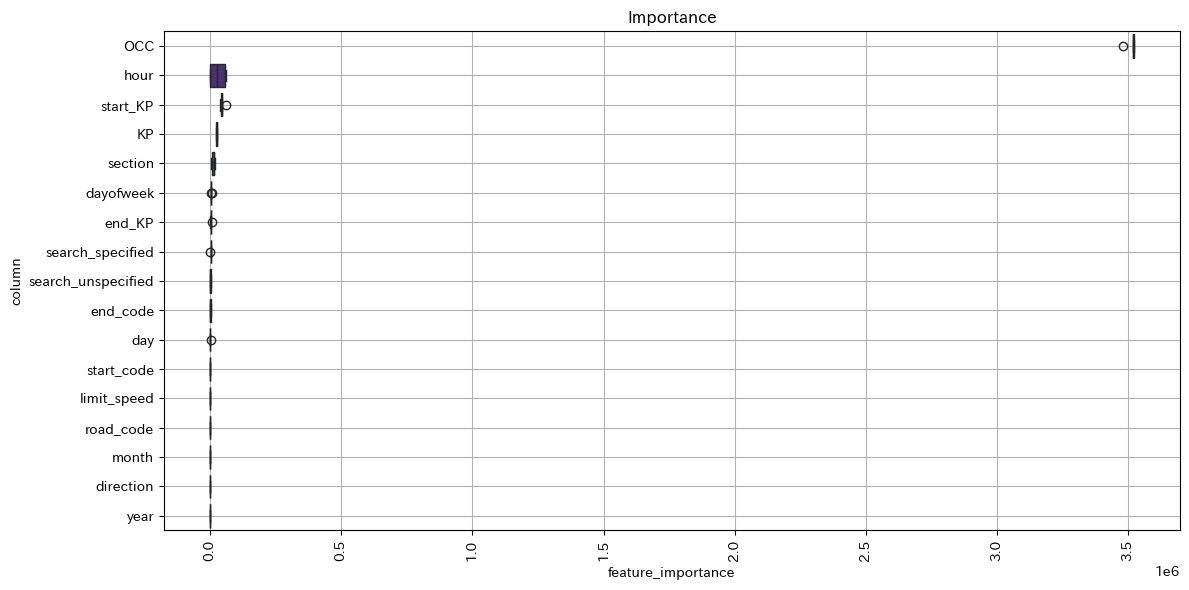

In [18]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])

# チュートリアル（ドラぷら検索ログの処理を含む）

In [16]:
# ========================================
# Library
# ========================================
import os
import math
import time
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

In [17]:
from expressway_router import ExpresswayRouter

road_all_csv = i_path + "road_all.csv"
road_local_csv = i_path + "road_local.csv"
router = ExpresswayRouter(road_all_csv=road_all_csv, road_local_csv=road_local_csv)

[ExpresswayRouter] Loading Road Network...
[ExpresswayRouter] Finished.


In [18]:
#2021年4月分のデータのみ抜き出す
log_pathes = glob(i_path + "/search_raw_log/2021_04_*.csv")
sorted_pathes = sorted(log_pathes, key=lambda x: datetime.strptime(os.path.basename(x), '%Y_%m_%d.csv'))
print(sorted_pathes[:5])

['../../train//search_raw_log/2021_04_01.csv', '../../train//search_raw_log/2021_04_02.csv', '../../train//search_raw_log/2021_04_03.csv', '../../train//search_raw_log/2021_04_04.csv', '../../train//search_raw_log/2021_04_05.csv']


In [19]:
rawlog_df = pd.concat([pd.read_csv(path) for path in sorted_pathes]).reset_index(drop=True)
rawlog_df = rawlog_df.astype({
    'datetime': 'datetime64[ns]',
    'start_code': 'category',
    'end_code': 'category',
    # 'spec_datetime': 'datetime64[ns]',
    'spec_type': 'category',
    'car_type': 'category'
    })
rawlog_df['spec_datetime'] = pd.to_datetime(rawlog_df['spec_datetime'], format='ISO8601')


In [20]:
rawlog_df.head(3)

,datetime,start_code,end_code,spec_datetime,spec_type,car_type
0,2021-04-01 00:00:01,6016021,1461150,2021-03-31 06:00:00,1,2
1,2021-04-01 00:00:06,214K106,1010066,2021-04-01 00:00:00,1,2
2,2021-04-01 00:00:06,6016021,1461150,2021-03-31 07:00:00,1,2


In [21]:
rawlog_df.tail(3)

,datetime,start_code,end_code,spec_datetime,spec_type,car_type
1911903,2021-04-30 23:59:53,1040076,1040061,2021-04-30 02:00:00,1,2
1911904,2021-04-30 23:59:53,1800061,1810026,2021-04-30 00:00:00,1,2
1911905,2021-04-30 23:59:55,1421003,1410001,2021-04-30 01:00:00,1,2


In [22]:
rawlog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1911906 entries, 0 to 1911905
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   datetime       datetime64[ns]
 1   start_code     category      
 2   end_code       category      
 3   spec_datetime  datetime64[ns]
 4   spec_type      category      
 5   car_type       category      
dtypes: category(4), datetime64[ns](2)
memory usage: 40.3 MB


In [23]:
def get_past_logs(df_log: pd.DataFrame, date: str, n_days: int) -> pd.DataFrame:
    '''
    df_logに含まれる、dateからn_days日前までの検索ログのうち、dateを指定日とするレコードを抜き出す
    '''
    end_timestamp = pd.Timestamp(date)
    start_timestamp = end_timestamp - pd.Timedelta(n_days, unit='day')
    
    df = df_log.loc[
        (df_log.datetime >= start_timestamp) & (df_log.datetime < end_timestamp)
    ]
    
    df_specified = df.loc[
        df.spec_datetime.dt.date == end_timestamp
    ].reset_index(drop=True)
    return df_specified

In [24]:
def create_expected_passing_time_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    '''
    検索ログdfの1レコードごとに検索経路が通過する各区間の予想通過時刻を計算する
    '''
    start_codes = []
    end_codes = []
    expected_passing_times = []
    
    columns = ['start_code', 'end_code', 'spec_datetime', 'spec_type']
    for (src, dest, spec_datetime, spec_type) in df.loc[:, columns].values:
        path_with_time = router.get_route_with_time(src, dest, spec_datetime, spec_type)
        
        for ((start_code, passing_time), (end_code, _)) in zip(path_with_time, path_with_time[1:]):
            start_codes.append(start_code)
            end_codes.append(end_code)
            expected_passing_times.append(passing_time)

    return pd.DataFrame({
        'start_code': start_codes,
        'end_code': end_codes,
        'passing_time': expected_passing_times
    }).astype({'start_code': 'category', 'end_code': 'category'})

In [26]:
data_period_dict = {
    'train': ('20210408', '20210430'), # サンプルとして1ヶ月を処理
    # 'test': ('20230801', '20230930'),
}

In [27]:
# 何日前までの検索履歴を参照するか
n_days = 7
# 検索数の時間粒度
sampling_rate = '1h'

## ドラぷら検索ログの処理

In [29]:
# 訓練データ期間
start_date, end_date = data_period_dict['train']
date_range = pd.date_range(start_date, end_date, freq='1d')

search_df = pd.DataFrame()
s = time.time()
for date in date_range:
    _s = time.time()
    
    past_logs_df = get_past_logs(rawlog_df, date, n_days=7)
    passing_df = create_expected_passing_time_dataframe(past_logs_df)
    
    _search_df = (passing_df.set_index('passing_time')
                  .assign(search_specified=1)
                  .groupby(['start_code', 'end_code'])
                  .apply(lambda g: g['search_specified'].resample(sampling_rate).sum())
                  # .apply(lambda g: g.resample(sampling_rate).sum())
                  .reset_index(drop=True))
    _search_df = _search_df.loc[_search_df['passing_time'].dt.date == date].reset_index(drop=True)

    
    search_df = pd.concat([search_df, _search_df], ignore_index=True)
    
    print(f'{date.date()} | {time.time() - _s : .3f} [sec]')

print('-'*30)
print(f'{start_date} --> {end_date} ({len(date_range)} days) | {time.time() - s : .3f} [sec]')

KeyError: 'passing_time'

In [ ]:
# テストデータ期間
# start_date, end_date = data_period_dict['test']
# date_range = pd.date_range(start_date, end_date, freq='1d')

# search_df = pd.DataFrame()
# s = time.time()
# for date in date_range:
#     _s = time.time()
    
#     past_logs_df = get_past_logs(rawlog_df, date, n_days=7)
#     passing_df = create_expected_passing_time_dataframe(past_logs_df)
    
#     _search_df = (passing_df.set_index('passing_time')
#                   .assign(search_specified=1)
#                   .groupby(['start_code', 'end_code'])
#                   .apply(lambda g: g['search_specified'].resample(sampling_rate).sum())
#                   .reset_index())
#     _search_df = _search_df.loc[_search_df.passing_time.dt.date == date].reset_index(drop=True)
    
#     search_df = pd.concat([search_df, _search_df], ignore_index=True)
    
#     print(f'{date.date()} | {time.time() - _s : .3f} [sec]')

# print('-'*30)
# print(f'{start_date} --> {end_date} ({len(date_range)} days) | {time.time() - s : .3f} [sec]')

In [ ]:
search_df.head()

In [ ]:
search_df.tail()

## トラカンデータとマージ

In [ ]:
column_types = {
    'datetime': np.datetime64,
    'start_code': str,
    'end_code': str,
}

train_df = pd.read_csv('train.csv').astype(column_types)
# test_df = pd.read_csv('test.csv').astype(column_types)

In [ ]:
# 訓練データ
train = train_df.merge(
    search_df,
    how='left',
    left_on=['datetime', 'start_code', 'end_code'],
    right_on=['passing_time', 'start_code', 'end_code']
).drop('passing_time', axis=1)

train['search_specified'] = train['search_specified'].fillna(0)


# テストデータ
# test = test_df.merge(
#     search_df,
#     how='left',
#     left_on=['datetime', 'start_code', 'end_code'],
#     right_on=['passing_time', 'start_code', 'end_code']
# ).drop('passing_time', axis=1)

# test['search_specified'] = test['search_specified'].fillna(0)

In [ ]:
train.head()